# RFM analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/_select_distinct_halfMD5_crm_contact_id_as_ClientID_transdate_as_202304131550.csv', encoding='cp1251')

In [ ]:
df.head()

,ClientID,date,Category,Sale_amount
0,11986856544773544099,2022-08-19,Уход,10470.0
1,16920200709491516826,2022-12-18,Уход за волосами,680.0
2,7617355293207308572,2022-05-09,Уход,638.0
3,8342290099479587359,2021-12-19,Уход,2375.0
4,4746383899659939558,2022-10-08,Уход за волосами,15380.0


## EDA

In [ ]:
df.info(null_counts=True, verbose=True)

<ipython-input-5-764979ca0b3e>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True, verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ClientID     2000000 non-null  uint64 
 1   date         2000000 non-null  object 
 2   Category     2000000 non-null  object 
 3   Sale_amount  2000000 non-null  float64
dtypes: float64(1), object(2), uint64(1)
memory usage: 61.0+ MB


Дата в формате object, переведем в формат даты

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
df['date'].describe(datetime_is_numeric=True)

count                          2000000
mean     2022-01-16 07:31:47.654401536
min                2016-01-01 00:00:00
25%                2021-05-16 00:00:00
50%                2022-04-08 00:00:00
75%                2022-11-21 00:00:00
max                2023-04-13 00:00:00
Name: date, dtype: object

Данные с 2016 года.  
Самая поздняя дата в датасете - 13.04.2023.   
В задании - провести анализ на 01.04.2023.  
Перед RFM анализом нужно ограничить дату по 01.04.2023.

In [ ]:
# вывод .value_counts() двумя столбцами -- количественно и в %
def f_value_counts(df, column):
    df_value_counts = pd.concat([
        df[column].value_counts(dropna=False),
        df[column].value_counts(normalize=True, dropna=False)
      ], axis=1
    )

    df_value_counts.columns = ['cnt', 'pct']

    return df_value_counts

Посмотрим наполненность данными по годам

In [ ]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [ ]:
f_value_counts(df, 'year')

,cnt,pct
2022,817332,0.408666
2021,483935,0.241968
2023,351137,0.175568
2020,257485,0.128743
2019,89605,0.044803
2016,177,0.000088
2017,169,0.000084
2018,160,0.000080


Очень мало данных за 2016-2018 гг.  
Возможно, стоит исключить эти данные, т.к. они могут давать выбросы в параметр recency

In [ ]:
# 3 знака после запятой
pd.options.display.float_format ='{:.3f}'.format

Изучим количество записей по каждому клиенту

In [ ]:
f_value_counts(df, 'ClientID')

,cnt,pct
5397303804906174911,1221,0.001
10233263390467858554,62,0.000
12730106014305082660,47,0.000
13315643414881508505,33,0.000
7176601937253783612,32,0.000
...,...,...
13391924810949332374,1,0.000
14915437105932576368,1,0.000
8316980994803593219,1,0.000
16503196957564265791,1,0.000


Один жирный клиент, который сделал 1221 покупку.  
Возможно, это какой-то крупный VIP клиент, о котором и так всем известно и его нужно исключить из анализа как выброс.  
Всего  1285595 уникальных клиентов в датасете

Структура данных по категориям

In [ ]:
f_value_counts(df, 'Category')

,cnt,pct
Уход,804066,0.402
Уход за волосами,739910,0.370
Для дома,154991,0.077
Макияж,122865,0.061
Детский мир,66514,0.033
Хоз.товары/бытовая химия,61888,0.031
Одежда и аксессуары,49522,0.025
Парфюмерия,216,0.000
Электротовары,17,0.000
Товары для животных,10,0.000


"Уход" и "Уход за волосами" - топ категории

Распределение по сумме покупки

In [ ]:
df['Sale_amount'].describe()

count    2000000.000
mean        2533.351
std        25323.278
min     -2347570.000
25%          379.000
50%          952.000
75%         2265.000
max      9320657.990
Name: Sale_amount, dtype: float64

<Axes: >

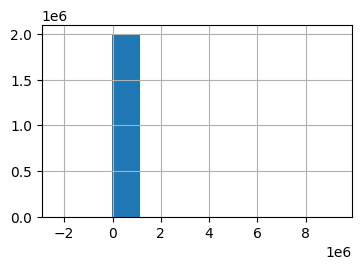

In [ ]:
df['Sale_amount'].hist(figsize=(4, 2.5))

Имеются отрицательные значения.  
И большие выбросы в +.  

Посмотрим на значение 99,9-перцентиля

In [ ]:
df['Sale_amount'].quantile(0.999)

87171.06000000983

<Axes: >

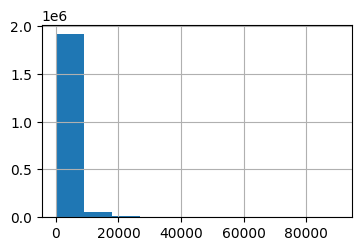

In [ ]:
df['Sale_amount'].hist(figsize=(4, 2.5), range=(0, 90000))

In [ ]:
df[df['Sale_amount'] >= df['Sale_amount'].quantile(0.999)]['ClientID'].nunique()

1251

Довольно много, 1251 клиент делает покупки на большие суммы.

Оценим количество строк с отрицательными значениями

In [ ]:
df[df['Sale_amount'] < 0]

,ClientID,date,Category,Sale_amount,year
3177,4337331835775219700,2022-09-30,Уход,-2900.000,2022
5737,996363205077702502,2020-01-20,Уход,-1294.000,2020
7025,17326045878336605467,2022-04-05,Уход,-469.000,2022
8716,14434296859356381222,2022-04-25,Уход,-2112.000,2022
10266,6228629198982066630,2021-04-17,Уход,-1737.000,2021
...,...,...,...,...,...
1997786,12406171418532161426,2022-11-03,Одежда и аксессуары,-494.000,2022
1997986,16308340943409609134,2021-08-05,Для дома,-419.000,2021
1998317,15652949524078701481,2022-11-18,Для дома,-3000.000,2022
1998700,15303273174086825935,2022-12-25,Уход,-5118.000,2022


In [ ]:
len(df[df['Sale_amount'] < 0]) / len(df)

0.000681

0.07% срок в датасете с отрицательными значениями

In [ ]:
len(df[df['Sale_amount'] == 0]) / len(df)

0.0023255

Еще 0.23% с нулевой суммой

Есть ли зависимость отрицательных значений от даты

In [ ]:
f_value_counts(df[df['Sale_amount'] < 0], 'year')

,cnt,pct
2022,836,0.614
2023,254,0.186
2021,244,0.179
2020,26,0.019
2019,2,0.001


Отрицательные значения встречаются в разные годы.

In [ ]:
f_value_counts(df[df['Sale_amount'] == 0], 'year')

,cnt,pct
2022,2747,0.591
2021,804,0.173
2023,643,0.138
2020,431,0.093
2019,26,0.006


Может быть это возвраты?

In [ ]:
df[df['Sale_amount'] < 0]['ClientID'].nunique()

1343

In [ ]:
len(set(df[df['Sale_amount'] < 0]['ClientID']) - set(df[df['Sale_amount'] >= 0]))

1343

In [ ]:
df[df['Sale_amount'] <= 0]['ClientID'].nunique()

5836

In [ ]:
len(set(df[df['Sale_amount'] <= 0]['ClientID']) - set(df[df['Sale_amount'] > 0]))

5836

У этих клиентов только отрицательные или нулевые транзакции. Транзакций с + суммой нет.   
Вряд ли это возвраты. Может быть ошибка в данных.  
Нужна дополнительная информация о природе отрицательных и нулевых значений.  
Далее эти строки будут исключены из анализа.

## RFM-calculation

Ограничим датасет по дате и сумме заказа

In [ ]:
df = (
    df[
        (df['Sale_amount'] > 0) &
        (df['date'].between('2019-01-01','2023-04-01')) &
        (df['ClientID'] != 5397303804906174911)
    ]
    .copy()
)

Создадим поле с id заказа

In [ ]:
df['order_id'] = [x for x in range(1, len(df)+1)]

In [ ]:
df['date'].max()

Timestamp('2023-04-01 00:00:00')

In [ ]:
analysis_date = df['date'].max()

In [ ]:
df_rfm = (
    df
    .groupby('ClientID', as_index=False)
    .agg({
        'date': lambda x: (analysis_date - x.max()).days, #Recency
        'order_id': 'nunique', #Frequency
        'Sale_amount': 'sum' #Monetary
        })
    .rename(columns={
        'date':'recency',
        'order_id':'frequency',
        'Sale_amount':'monetary'
        })
)

In [ ]:
df_rfm

,ClientID,recency,frequency,monetary
0,930272754058,412,1,1811.000
1,22235420299089,584,1,86.100
2,27524407622190,97,1,43.290
3,31545684321235,207,1,850.000
4,41623521047239,198,1,2088.000
...,...,...,...,...
1260732,18446683648701901454,34,2,3172.000
1260733,18446695282697101421,266,3,2362.000
1260734,18446699183196947428,23,1,8784.000
1260735,18446727504087627505,2,1,675.000


Посмотрим на распределения RFM-метрик

In [ ]:
df_rfm[['recency', 'frequency', 'monetary']].describe()

,recency,frequency,monetary
count,1260737.000,1260737.000,1260737.000
mean,368.289,1.549,3485.688
std,334.638,1.141,8072.367
min,0.000,1.000,0.320
25%,98.000,1.000,528.000
50%,259.000,1.000,1425.000
75%,555.000,2.000,3600.000
max,1447.000,62.000,1074127.000


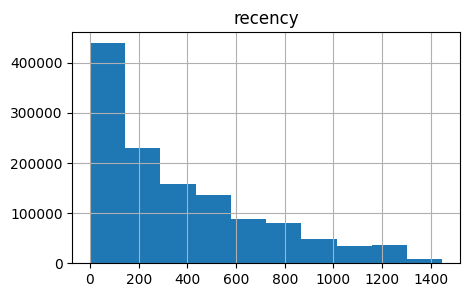

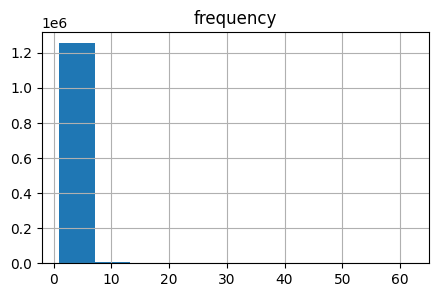

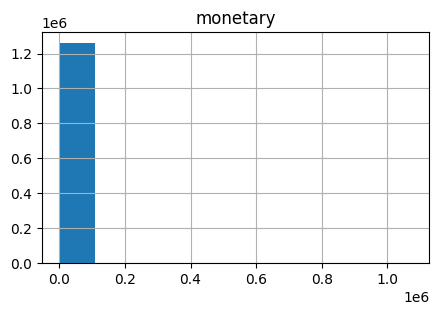

In [ ]:
for col in ['recency', 'frequency', 'monetary']:
  df_rfm[col].hist(figsize=(5,3))
  plt.title(col)
  plt.show()

По квантилям имеет смысл разбивать только параметр recency.  
По частоте покупок как минимум 75% клиентов делали не более 2х заказов.  
Общая стоимость покупок имеет большие выбросы в плюс.

### Recency score

In [ ]:
# клиенты, которые проявляли активность недавно, будут иметь максимальный скор, которые давно не появлялись - минимальный скор
df_rfm['r_score'] = pd.qcut(df_rfm['recency'],
                              q=4,
                              labels=[4, 3, 2, 1])

In [ ]:
df_rfm

,ClientID,recency,frequency,monetary,r_score
0,930272754058,412,1,1811.000,2
1,22235420299089,584,1,86.100,1
2,27524407622190,97,1,43.290,4
3,31545684321235,207,1,850.000,3
4,41623521047239,198,1,2088.000,3
...,...,...,...,...,...
1260732,18446683648701901454,34,2,3172.000,4
1260733,18446695282697101421,266,3,2362.000,2
1260734,18446699183196947428,23,1,8784.000,4
1260735,18446727504087627505,2,1,675.000,4


### Frequency score

In [ ]:
f_value_counts(df_rfm, 'frequency').head(10)

,cnt,pct
1,876618,0.695
2,228972,0.182
3,83693,0.066
4,35534,0.028
5,16815,0.013
6,8519,0.007
7,4544,0.004
8,2512,0.002
9,1315,0.001
10,813,0.001


<Axes: >

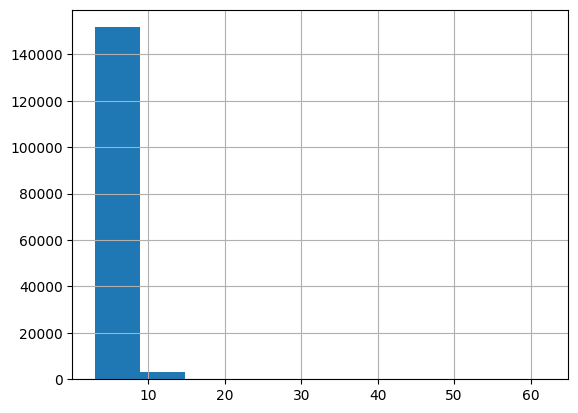

In [ ]:
df_rfm[df_rfm['frequency'] > 2]['frequency'].hist()

In [ ]:
df_rfm[df_rfm['frequency'] > 2]['frequency'].quantile(0.999)

16.0

Т.к. у нас 70% клиентов совершили только одну покупку, еще 18% - две покупки, остальные в большинстве своем от 2 до 16 покупок, разделим frequency так:  
1 - совершил одну покупку (нет повторных покупок)  
2 - совершил 2 покупки  
3 - несколько покупок (3-16)  
4 - совершил много покупок (16-62)  

In [ ]:
df_rfm.loc[df_rfm['frequency'] == 1, 'f_score'] = 1
df_rfm.loc[df_rfm['frequency'] == 2, 'f_score'] = 2
df_rfm.loc[df_rfm['frequency'].between(3, 15), 'f_score'] = 3
df_rfm.loc[df_rfm['frequency'] > 15, 'f_score'] = 4

In [ ]:
df_rfm = df_rfm.astype({'f_score':'int'})

In [ ]:
df_rfm

,ClientID,recency,frequency,monetary,r_score,f_score
0,930272754058,412,1,1811.000,2,1
1,22235420299089,584,1,86.100,1,1
2,27524407622190,97,1,43.290,4,1
3,31545684321235,207,1,850.000,3,1
4,41623521047239,198,1,2088.000,3,1
...,...,...,...,...,...,...
1260732,18446683648701901454,34,2,3172.000,4,2
1260733,18446695282697101421,266,3,2362.000,2,3
1260734,18446699183196947428,23,1,8784.000,4,1
1260735,18446727504087627505,2,1,675.000,4,1


### Monetary score

In [ ]:
df_rfm['monetary'].describe()

count   1260737.000
mean       3485.688
std        8072.367
min           0.320
25%         528.000
50%        1425.000
75%        3600.000
max     1074127.000
Name: monetary, dtype: float64

<Axes: >

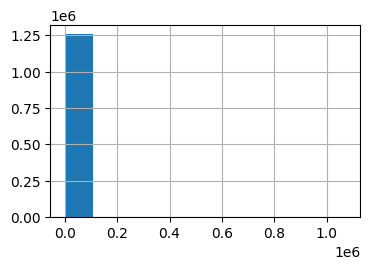

In [ ]:
df_rfm['monetary'].hist(figsize=(4,2.5))

Есть какие-то супер дешевые копеечные обороты по заказам и есть супер большие обороты у одного клиента.  

In [ ]:
df_rfm['monetary'].quantile(0.001)

5.2

In [ ]:
df_rfm['monetary'].quantile(0.999)

97222.27200001455

In [ ]:
df_rfm[df_rfm['monetary'].between(
    df_rfm['monetary'].quantile(0.001),
    df_rfm['monetary'].quantile(0.999)
    )
]['monetary'].describe()

count   1258232.000
mean       3338.708
std        6102.935
min           5.200
25%         529.000
50%        1425.000
75%        3600.000
max       97203.000
Name: monetary, dtype: float64

Супер маленьким оборотам присвоим сразу значение = 1, а супер большим = 4. Середину между ними разобьем на квартили.  

In [ ]:
df_rfm.loc[df_rfm['monetary'] <= df_rfm['monetary'].quantile(0.001), 'm_score'] = 1
df_rfm.loc[df_rfm['monetary'] >= df_rfm['monetary'].quantile(0.999), 'm_score'] = 4

In [ ]:
t1 = df_rfm[~df_rfm['monetary'].between(
                                df_rfm['monetary'].quantile(0.001),
                                df_rfm['monetary'].quantile(0.999))].copy()
t2 = df_rfm[df_rfm['monetary'].between(
                                df_rfm['monetary'].quantile(0.001),
                                df_rfm['monetary'].quantile(0.999))].copy()

In [ ]:
t2['m_score'] = pd.qcut(t2['monetary'],
                              q=4,
                              labels=[1, 2, 3, 4])

In [ ]:
rfm = (
    pd.concat([t1, t2], axis=0).astype({'m_score':'int'})
)

In [ ]:
rfm

,ClientID,recency,frequency,monetary,r_score,f_score,m_score
302,4057065041346987,18,2,100373.000,4,2,4
891,12892171653734017,97,1,4.990,4,1,1
1081,15542215934593028,114,3,108900.000,3,3,4
1447,20854377475730383,63,2,263149.000,4,2,4
2802,40961108096338125,129,1,111753.000,3,1,4
...,...,...,...,...,...,...,...
1260732,18446683648701901454,34,2,3172.000,4,2,3
1260733,18446695282697101421,266,3,2362.000,2,3,3
1260734,18446699183196947428,23,1,8784.000,4,1,4
1260735,18446727504087627505,2,1,675.000,4,1,2


In [ ]:
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

In [ ]:
rfm

,ClientID,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
302,4057065041346987,18,2,100373.000,4,2,4,424
891,12892171653734017,97,1,4.990,4,1,1,411
1081,15542215934593028,114,3,108900.000,3,3,4,334
1447,20854377475730383,63,2,263149.000,4,2,4,424
2802,40961108096338125,129,1,111753.000,3,1,4,314
...,...,...,...,...,...,...,...,...
1260732,18446683648701901454,34,2,3172.000,4,2,3,423
1260733,18446695282697101421,266,3,2362.000,2,3,3,233
1260734,18446699183196947428,23,1,8784.000,4,1,4,414
1260735,18446727504087627505,2,1,675.000,4,1,2,412


## RFM-segmentation

Выделим следующие сегменты:  

**top** - топ-клиенты, были недавно, ходят часто, приносят деньги. Их нельзя потерять.    
**loyal_high_value** - лояльные клиенты, были на обозримом горизонте в прошлом, совершают повторные покупки, при этом приносят выручку. Потенциальные топ-клиенты, их нельзя потерять.  
**loyal_low_value** - лояльные клиенты, были на обозримом горизонте в прошлом, совершают повторные покупки, при этом приносят мало выручки. Нужно стимулировать их на более крупные покупки.  
**at_risk** - лояльные и топ-клиенты, которые в прошлом совершали повторные покупки и приносили деньги, но этих клиентов давно не было. Нужны воздействия по удержанию, реактивации.  
**new_recent_high_value** - недавно совершили первую или вторую покупку, при этом принесли хорошую выручку. Потенциальные лояльные клиенты, их нужно развивать/поощрять, чтобы они стали лояльными.
**new_recent_low_value** - недавно совершили первую или вторую покупку, но на небольшую сумму. Этих клиентов нужно развивать, стимулировать к увеличению оборотов, чтобы они стали лояльными.  
**sleeping** - в прошлом совершали покупки (повторные) / приносили выручку, но мы их давно невидели.  
**lost_low_value** - клиенты, которые были очень давно, совершили мало покупок, принесли мало выручки / либо очень давняя единоразовая покупка на крупную сумму.   







In [ ]:
segments = {
    'lost_low_value':['111', '112', '113', '114', '121', '122','211','212','213', '214', '221'],
    'sleeping':['123', '124', '131', '132','222', '223','224','231','232'],
    'at_risk':['133', '134', '144','233','234', '244'],
    'loyal_high_value':['333','334', '433', '343'],
    'top':['344', '434', '444', '443'],
    'loyal_low_value':['331', '332', '431', '432'],
    'new_recent_high_value':['313', '314','413', '414','323', '324', '423', '424'],
    'new_recent_low_value':['311', '312', '411', '412', '321', '322','421', '422']
    }

In [ ]:
for segment in segments.keys():
  rfm.loc[rfm['rfm_score'].isin(segments[segment]), 'segment'] = segment

In [ ]:
rfm.head()

,ClientID,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
302,4057065041346987,18,2,100373.000,4,2,4,424,new_recent_high_value
891,12892171653734017,97,1,4.990,4,1,1,411,new_recent_low_value
1081,15542215934593028,114,3,108900.000,3,3,4,334,loyal_high_value
1447,20854377475730383,63,2,263149.000,4,2,4,424,new_recent_high_value
2802,40961108096338125,129,1,111753.000,3,1,4,314,new_recent_high_value


In [ ]:
# проверка, что каждому rfm-score присвоен сегмент
rfm[rfm['segment'].isna()]

,ClientID,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment


Как разделилась клиентская база на сегменты:

In [ ]:
f_value_counts(rfm, 'segment')

,cnt,pct
lost_low_value,505659,0.401
new_recent_high_value,265232,0.210
new_recent_low_value,257269,0.204
sleeping,84030,0.067
loyal_high_value,55835,0.044
top,43856,0.035
at_risk,40655,0.032
loyal_low_value,8201,0.007


40% базы - наибольший сегмент - это клиенты, которые давно потеряны и которые не принесли денег бизнесу.  
Топ клиенты составляют 3.5% от базы,  
лояльные, приносящие деньги, - 4.4% от базы.   
Основной потенциал в новых клиентах, которые были недавно и совершили свои первые покупки,в сумме они составляют ~ 41% базы. Нужно развивать и воздействовать на этих клиентов, чтобы они переходили в сегменты ТОП и лояльных клентов.  

In [ ]:
rfm.to_csv('rfm_result.csv', index=False, header=True)

In [ ]:
!jupyter nbconvert --to html /content/rfm.ipynb

[NbConvertApp] Converting notebook /content/rfm.ipynb to html
[NbConvertApp] Writing 902550 bytes to /content/rfm.html
